Dataset Contents: ['Training', 'Testing']


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 179MB/s]
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 198MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [1/100], Loss: 102.7793, Train Acc: 95.03%, Val Acc: 95.50%
Epoch [2/100], Loss: 85.3383, Train Acc: 98.18%, Val Acc: 97.64%
Epoch [3/100], Loss: 82.9800, Train Acc: 98.62%, Val Acc: 97.56%
Epoch [4/100], Loss: 82.5946, Train Acc: 98.58%, Val Acc: 97.71%
Epoch [5/100], Loss: 81.9798, Train Acc: 98.72%, Val Acc: 98.02%
Epoch [6/100], Loss: 80.6364, Train Acc: 99.05%, Val Acc: 97.86%
Epoch [7/100], Loss: 81.4378, Train Acc: 98.70%, Val Acc: 97.94%
Epoch [8/100], Loss: 80.0489, Train Acc: 98.97%, Val Acc: 97.94%
Epoch [9/100], Loss: 78.5833, Train Acc: 99.28%, Val Acc: 98.25%
Epoch [10/100], Loss: 79.5089, Train Acc: 99.09%, Val Acc: 97.79%
Epoch [11/100], Loss: 79.3741, Train Acc: 99.00%, Val Acc: 98.86%
Epoch [12/100], Loss: 78.0899, Train Acc: 99.19%, Val Acc: 98.93%
Epoch [13/100], Loss: 77.8194, Train Acc: 99.21%, Val Acc: 99.01%
Epoch [14/100], Loss: 77.6514, Train Acc: 99.23%, Val Acc: 98.70%
Epoch [15/100], Loss: 77.2510, Train Acc: 99.26%, Val Acc: 98.63%
Epoch [16/100], Lo

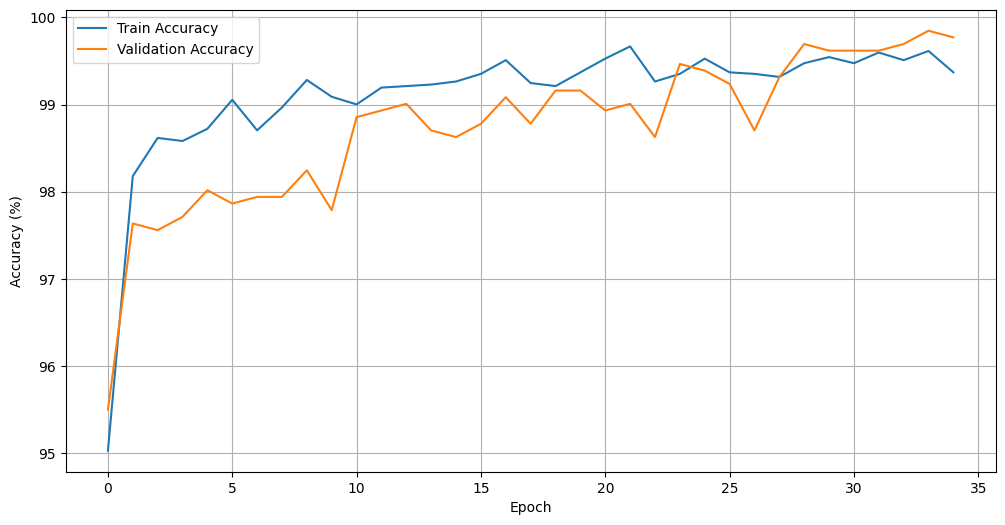


Best Validation Accuracy Achieved: 99.85%
              precision    recall  f1-score   support

    No Tumor       1.00      1.00      1.00       405
       Tumor       1.00      1.00      1.00       906

    accuracy                           1.00      1311
   macro avg       1.00      1.00      1.00      1311
weighted avg       1.00      1.00      1.00      1311



In [ ]:
import os
import zipfile
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# =======================
# 1. Unzip the Dataset
# =======================
zip_file_path = '/content/archive (8).zip'  # Update path if needed
dataset_path = '/content/dataset1'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

print("Dataset Contents:", os.listdir(dataset_path))

# =======================
# Setting Seeds for Reproducibility
# =======================
seed = 46
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# =======================
# 2. Define the Hybrid Model
# =======================
class MobileNetV3SqueezeNetEnsemble(nn.Module):
    def __init__(self):
        super(MobileNetV3SqueezeNetEnsemble, self).__init__()

        # Load pre-trained MobileNetV3 and SqueezeNet
        self.mobilenet = models.mobilenet_v3_large(weights='IMAGENET1K_V1')
        self.squeezenet = models.squeezenet1_1(weights='IMAGENET1K_V1')

        # Remove classifier layers
        self.mobilenet.classifier = nn.Identity()
        self.squeezenet.classifier = nn.Identity()

        # Adaptive pooling for consistent feature sizes
        self.pool_mobilenet = nn.AdaptiveAvgPool2d((1, 1))
        self.pool_squeezenet = nn.AdaptiveAvgPool2d((1, 1))

        # Define the final fully connected layers
        self.fc1 = nn.Linear(960 + 512, 1024)  # Reduce complexity
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.6)  # More stable dropout
        self.fc2 = nn.Linear(1024, 2)  # Binary classification (tumor vs no tumor)

    def forward(self, x):
        x1 = self.mobilenet.features(x)
        x1 = self.pool_mobilenet(x1)
        x1 = x1.view(x1.size(0), -1)

        x2 = self.squeezenet.features(x)
        x2 = self.pool_squeezenet(x2)
        x2 = x2.view(x2.size(0), -1)

        x = torch.cat((x1, x2), dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# =======================
# 3. Data Preparation with Augmentation
# =======================

# Binary Class Mapping (Tumor = 1, No Tumor = 0)
tumor_classes = ['glioma', 'pituitary', 'meningioma']
no_tumor_classes = ['notumor']

binary_class_mapping = {cls: 1 for cls in tumor_classes}
binary_class_mapping.update({cls: 0 for cls in no_tumor_classes})

def binary_target_transform(target):
    class_name = train_dataset.classes[target]
    return binary_class_mapping[class_name]

# Transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.6),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomAffine(degrees=20, shear=10),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Apply Binary Mapping without Moving Folders
train_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'Training'), transform=train_transforms, target_transform=binary_target_transform)
val_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'Testing'), transform=val_transforms, target_transform=binary_target_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# =======================
# 4. Define Model, Optimizer, Scheduler, and Criterion
# =======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetV3SqueezeNetEnsemble().to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.00008, weight_decay=0.003)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0.00001)
# =======================
# 5. Training and Validation
# =======================
train_accuracies = []
val_accuracies = []
best_accuracy = 0.0

for epoch in range(35):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    # Validation Phase
    model.eval()
    val_correct = 0
    val_total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            outputs = model(val_images)
            _, val_predicted = torch.max(outputs, 1)

            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

            all_labels.extend(val_labels.cpu().numpy())
            all_predictions.extend(val_predicted.cpu().numpy())

    val_accuracy = 100 * val_correct / val_total
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), f"/content/best_model{epoch+1}_{val_accuracy:.2f}.pth")

    scheduler.step(val_accuracy)

    print(f"Epoch [{epoch+1}/100], Loss: {running_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")

# =======================
# 6. Plot Training and Validation Accuracies
# =======================
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()

print(f"\nBest Validation Accuracy Achieved: {best_accuracy:.2f}%")
print(classification_report(all_labels, all_predictions, target_names=['No Tumor', 'Tumor']))
